In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-07-16 21:08:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.140.128, 173.194.76.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.140.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  56.6MB/s    in 2.5s    

2020-07-16 21:08:41 (56.6 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-07-16 21:08:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11

In [2]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/train')

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [3]:
train_horse_dir = os.path.join('/tmp/train/horses')
train_human_dir = os.path.join('/tmp/train/humans')

validation_horse_dir = os.path.join('/tmp/validation/horses')
validation_human_dir = os.path.join('/tmp/validation/humans')

## Sample Images

In [4]:
names_train_horse = os.listdir(train_horse_dir)
names_validation_horse = os.listdir(validation_horse_dir)
names_train_human = os.listdir(train_human_dir)
names_validation_human = os.listdir(validation_human_dir)

print(names_train_horse[:5])
print(names_validation_horse[:5])
print(names_train_human[:5])
print(names_validation_human[:5])

['horse11-8.png', 'horse26-3.png', 'horse36-3.png', 'horse39-3.png', 'horse35-4.png']
['horse5-458.png', 'horse5-164.png', 'horse1-241.png', 'horse2-582.png', 'horse5-203.png']
['human08-03.png', 'human17-11.png', 'human02-21.png', 'human09-17.png', 'human17-30.png']
['valhuman05-20.png', 'valhuman02-01.png', 'valhuman04-05.png', 'valhuman01-06.png', 'valhuman05-12.png']


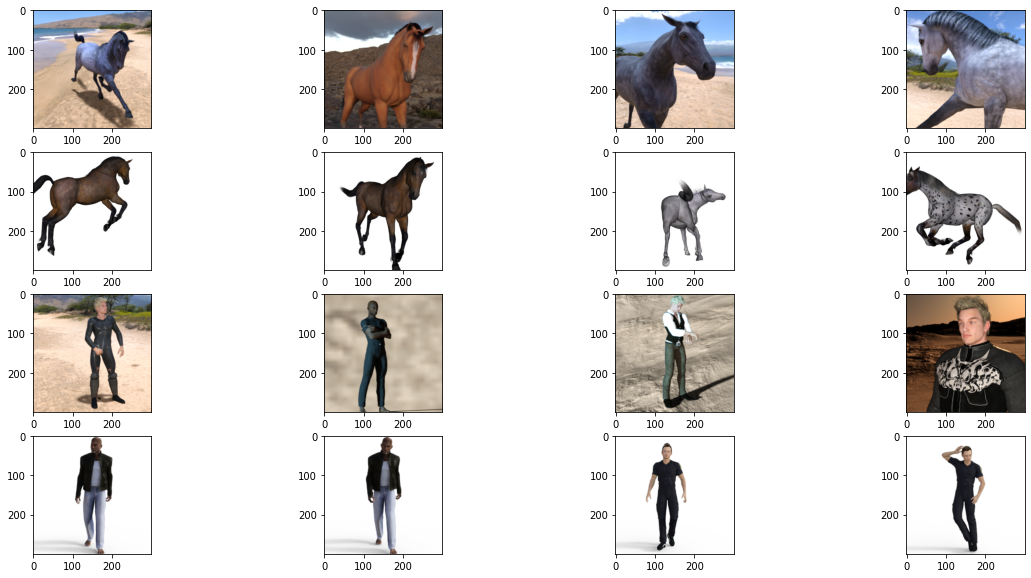

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(20, 10))

for i in range(4):
  plt.subplot(4, 4, i+1)
  n = random.randrange(len(os.listdir(train_horse_dir)))
  img = mpimg.imread(os.path.join(train_horse_dir, names_train_horse[n]))
  plt.imshow(img)

  plt.subplot(4, 4, i+5)
  n = random.randrange(len(os.listdir(validation_horse_dir)))
  img = mpimg.imread(os.path.join(validation_horse_dir, names_validation_horse[n]))
  plt.imshow(img)

  plt.subplot(4, 4, i+9)
  n = random.randrange(len(os.listdir(train_human_dir)))
  img = mpimg.imread(os.path.join(train_human_dir, names_train_human[n]))
  plt.imshow(img)

  plt.subplot(4, 4, i+13)
  n = random.randrange(len(os.listdir(validation_human_dir)))
  img = mpimg.imread(os.path.join(validation_human_dir, names_validation_human[n]))
  plt.imshow(img)

# Data Preprocessing

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/tmp/train/',
                                                    target_size=(300, 300),
                                                    batch_size=128,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory('/tmp/validation/',
                                                    target_size=(300, 300),
                                                    batch_size=32,
                                                    class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Creating Model

In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
   
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   
    # Flatten the results to feed into a DNN 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Only 1 output neuron
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
dropout_3 (Dropout)          (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 71, 71, 64)       

In [15]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [16]:
history = model.fit(train_generator, 
                    epochs=30, 
                    verbose=1, 
                    validation_data = validation_generator)

Epoch 1/30
9/9 [==============================] - 15s 2s/step - loss: 1.3929 - accuracy: 0.5433 - val_loss: 0.6985 - val_accuracy: 0.5000
Epoch 2/30
9/9 [==============================] - 14s 2s/step - loss: 0.8465 - accuracy: 0.5638 - val_loss: 0.6912 - val_accuracy: 0.5156
Epoch 3/30
9/9 [==============================] - 14s 2s/step - loss: 0.5967 - accuracy: 0.7205 - val_loss: 0.8258 - val_accuracy: 0.5000
Epoch 4/30
9/9 [==============================] - 14s 2s/step - loss: 0.5403 - accuracy: 0.7634 - val_loss: 0.7360 - val_accuracy: 0.5000
Epoch 5/30
9/9 [==============================] - 14s 2s/step - loss: 0.5024 - accuracy: 0.7731 - val_loss: 0.6137 - val_accuracy: 0.6797
Epoch 6/30
9/9 [==============================] - 14s 2s/step - loss: 0.3285 - accuracy: 0.8471 - val_loss: 0.8732 - val_accuracy: 0.5430
Epoch 7/30
9/9 [==============================] - 14s 2s/step - loss: 0.3268 - accuracy: 0.8880 - val_loss: 1.2174 - val_accuracy: 0.5234
Epoch 8/30
9/9 [==================

<Figure size 432x288 with 0 Axes>

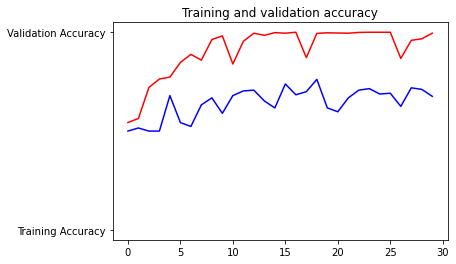

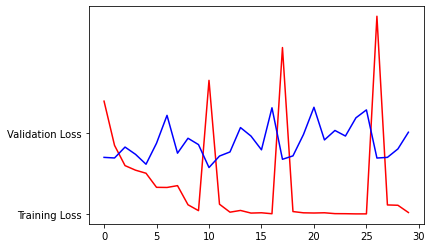

<Figure size 432x288 with 0 Axes>

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()